In [26]:
import os
import os.path as osp
from PIL import Image
import pandas as pd
from torch.utils.data.dataset import Dataset
import numpy as np

In [63]:
import matplotlib.pyplot as plt

def imshow_pair(im, gdt):
    f, ax = plt.subplots(1, 2, figsize=(12,6))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

In [18]:
data_path = '../data/DRIVE/'

In [48]:
im_list = pd.read_csv(osp.join(data_path, 'test.csv')).vessel_paths.values

In [49]:
im_list = ['../'+n for n in im_list]

In [50]:
im1, im2 = Image.open(im_list[0]), Image.open(im_list[3])

In [51]:
im_list[0]

'../data/DRIVE/manual/01_manual1.gif'

In [52]:
im11 = Image.open('../2nd_manual/01_manual2.gif')

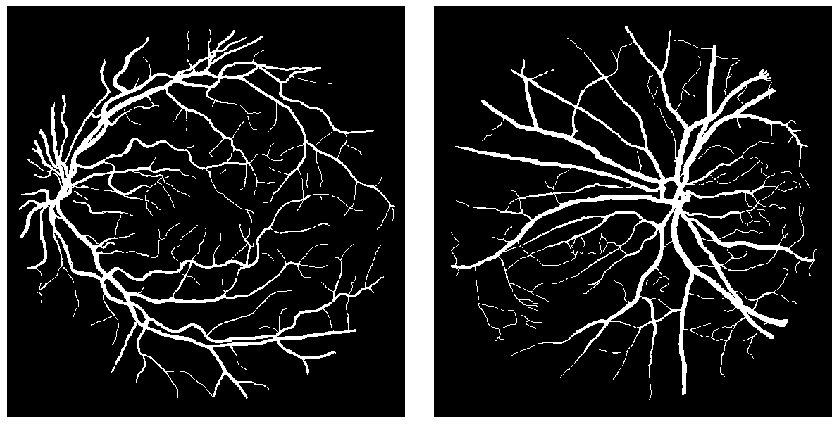

In [64]:
imshow_pair(im1,im2)

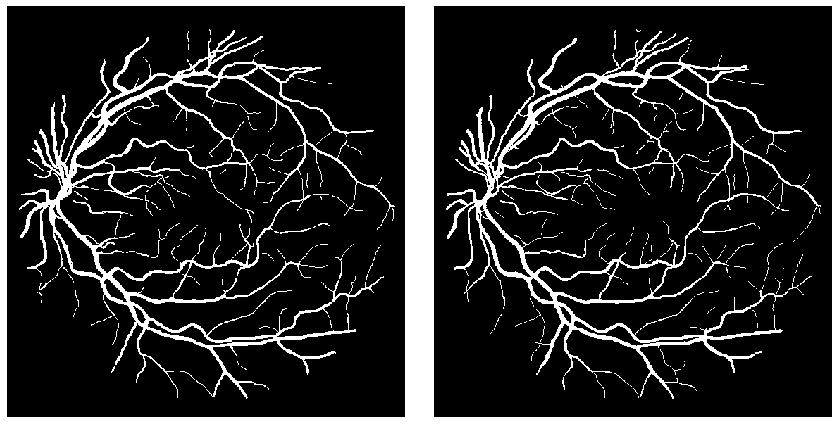

In [65]:
imshow_pair(im1,im11)

In [87]:
def mutual_information(im1, im2):
    # assumes images contain integer values in [0,255]
    X = np.array(im1).astype(float)
    Y = np.array(im2).astype(float)
    hist_2d, _, _ = np.histogram2d(X.ravel(),Y.ravel(),bins=255)
    pxy = hist_2d / float(np.sum(hist_2d)) # joint probability distribution
    
    px = np.sum(pxy, axis=1) # marginal distribution for x over y
    py = np.sum(pxy, axis=0) # marginal distribution for y over x
    
    Hx = - sum(px*np.log(px + (px==0))) # Entropy of X
    Hy = - sum(py*np.log(py + (py==0))) # Entropy of Y
    Hxy = np.sum(-(pxy*np.log(pxy+(pxy==0))).ravel())# Joint Entropy
    
    
    M = Hx+Hy-Hxy # mutual information
    nmi = 2*(M/(Hx+Hy)) # normalized mutual information
    return nmi

In [88]:
# same in sklearn, 4 times slower:
# from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score
# normalized_mutual_info_score(np.array(im1).ravel(), np.array(im2).ravel())

In [89]:
mutual_information(im1, im2)

0.001008415336892537

In [90]:
mutual_information(im1,im11)

0.5665034843386163

# Process patches, put them back

In [118]:
from skimage.morphology import binary_erosion, selem
from skimage import img_as_ubyte

In [148]:
def erode_patch(patch):
    return 255*binary_erosion(patch, selem=selem.rectangle(3, 3))

In [120]:
def process_patch(im, xi, yi, patch_size):
    im[yi:yi+patch_size[0], xi:xi+patch_size[1]] = erode_patch(im[yi:yi+patch_size[0], xi:xi+patch_size[1]])
    return im

In [165]:
# %%timeit
im1_e = process_patch(np.array(im1), 50, 50, [400,400])

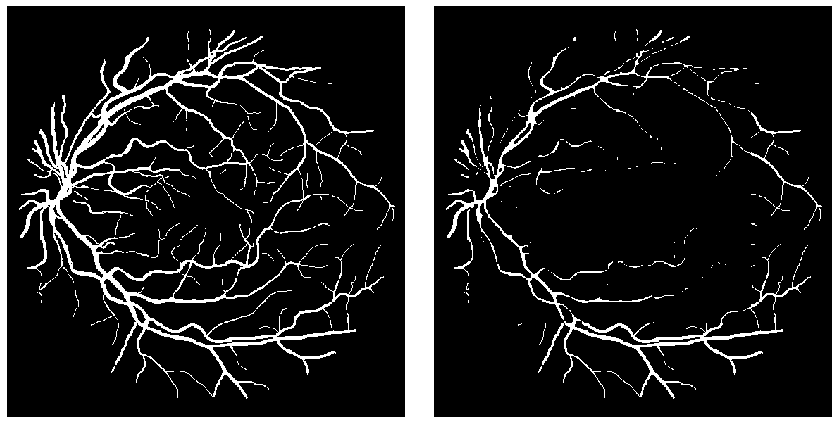

In [166]:
imshow_pair(im1, im1_e)

In [167]:
mutual_information(im1,im1_e)

0.5085069303487093

In [176]:
im1_zeros = np.zeros(im1_e.shape, dtype=bool)
im1_ones = np.ones(im1_e.shape, dtype=bool)

In [177]:
from sklearn.metrics import f1_score

In [178]:
f1_score(np.array(im1).astype(bool).ravel(), im1_e.astype(bool).ravel())

0.6767052477806496

In [179]:
f1_score(np.array(im1).astype(bool).ravel(), im1_zeros.astype(bool).ravel())

0.0

In [180]:
f1_score(np.array(im1).astype(bool).ravel(), im1_ones.astype(bool).ravel())

0.16382860322760157

In [181]:
f1_score(np.array(im1).astype(bool).ravel(), (255-np.array(im1)).astype(bool).ravel())

0.0

In [183]:
mutual_information(im1, im1_zeros)

0.0

In [184]:
mutual_information(im1, im1_ones)

0.0

In [185]:
mutual_information(im1,255-np.array(im1))

1.0